# Check the position of visits in Auxtel

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-04-13
- last update : 2024-05-07 
- affiliation : IJCLab/IN2P3/CNRS

  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.colors import ListedColormap
from matplotlib import colors

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time
from datetime import datetime, timedelta
import seaborn as sns

from itertools import cycle, islice
import os

In [2]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom

from astropy.stats import SigmaClip


In [3]:
# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"


collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collectionn = collection
collections = [collection]
collectionStr = collectionn.replace("/", "_")
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract_sel = 3864
#band = "r"
suptitle = collectionStr + f" inst = {instrument} tract = {tract_sel}"

where_clause = "instrument = \'" + instrument+ "\'"
NDET = 1

fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"

In [4]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [5]:
def angle_in_range(alpha, lower, upper):
    return (alpha - lower) % 360 <= (upper - lower) % 360

In [6]:
def get_bbox_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    ramin,ramax,decmin,decmax in decimal degrees
    """

    xmin = bbox.beginX
    xmax = bbox.endX
    ymin = bbox.beginY
    ymax = bbox.endY
    
    radec_ll = wcs.pixelToSky(xmin, ymin)
    radec_ur = wcs.pixelToSky(xmax, ymax)
        
    return radec_ur.getRa().asDegrees(),radec_ll.getRa().asDegrees(), radec_ll.getDec().asDegrees(),radec_ur.getDec().asDegrees() 


In [7]:
def isradec_inbbox_radec(ra,dec,wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """

    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, bbox)

    flag_ra = angle_in_range(ra,RAMIN,RAMAX)
    flag_dec = angle_in_range(dec,DECMIN,DECMAX)

    flag = flag_ra and flag_dec
    return flag


In [8]:
def FindTractAndPatch(row):
    """
    Apply this function on ccdvisitTable dataframe to find the tract and patch for each visit
    """
     
    try:
        ra = row["ra"]
        dec = row["dec"]
        selectFlag = False
        # loop on tract
        for tractID in tractsId_list:
            tractInfo = skymap.generateTract(tractID)
            patches_selected = [patch.getSequentialIndex() for patch in tractInfo]
            wcs=tractInfo.getWcs()
            # loop on patches
            for patch in tractInfo:
                patchID = patch.getSequentialIndex()
                if patchID in patches_selected:
                    ibb=patch.getInnerBBox()
                    flag = isradec_inbbox_radec(ra,dec,wcs, ibb)
                    selectFlag =  selectFlag or flag
                    if selectFlag:
                        return pd.Series([tractID,patchID])
        return pd.Series([0,0])           
                
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        return pd.Series([0,0])  
        


## Iteration

## Initiate the butler

In [9]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LATISS
collections = ['LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985']


In [10]:
skymap = butler.get('skyMap', skymap=skymapName, collections=collections)

In [11]:
datasetRefs = butler.registry.queryDatasets(datasetType='ccdVisitTable', collections=collections, where= where_clause)

## tracts and patches

In [12]:
nImage_refs = list(butler.registry.queryDatasets('deepCoadd_nImage'))

In [13]:
tractsId_list = np.unique([ref.dataId['tract'] for ref in nImage_refs])
tractsId_list = sorted(tractsId_list)
print(tractsId_list)

[3864, 5614, 5615, 5634]


In [14]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': instrument}, collections = collections )    

In [15]:
ccd_visit_table["ccdVid"] = ccd_visit_table.index -  ccd_visit_table.index[0]
ccd_visit_table["Vid"] = ccd_visit_table["visitId"]  -   ccd_visit_table["visitId"].iloc[0]

In [16]:
#subtract the a bug number to have normal dates
ccd_visit_table["nightObs"] = ccd_visit_table.apply(lambda x: x['visitId']//100_000, axis=1)
ccd_visit_table["nightObs"]

ccdVisitId
40919696896    20230511
40919697408    20230511
40919698432    20230511
40919698944    20230511
40919699200    20230511
                 ...   
43453134336    20240308
43453134592    20240308
43453134848    20240308
43453135104    20240308
43453135360    20240308
Name: nightObs, Length: 3993, dtype: int64

In [17]:
#ccd_visit_table_subset = ccd_visit_table[["ra","dec"]].iloc[:10]
#ccd_visit_table_subset[["tractID","patchID"]] =  ccd_visit_table_subset.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [18]:
# to speed up the calculation of tractID, patchID per visit, this file is saved
# or read back
if os.path.isfile(fn_ccdVisit_tracts_patches):
    print(f"{fn_ccdVisit_tracts_patches} found !!! ==> Read it !!!" )
    ccd_visit_tract_patch_table = pd.read_csv(fn_ccdVisit_tracts_patches) 
    ccd_visit_tract_patch_table.set_index("ccdVisitId",inplace=True)
    ccd_visit_tract_patch_table_only = ccd_visit_tract_patch_table[["tractID","patchID"]]
    ccd_visit_table = ccd_visit_table.join(ccd_visit_tract_patch_table_only)
else:
    print(f"{fn_ccdVisit_tracts_patches} NOT found !!! ==> Create it !!! " )
    ccd_visit_table[["tractID","patchID"]] = ccd_visit_table.apply(FindTractAndPatch, axis=1,result_type ='expand')
    columns_selected = ["ra","dec","llcra","llcdec","ulcra","ulcdec","urcra","urcdec","lrcra","lrcdec","ccdVid","Vid","nightObs","tractID","patchID","zeroPoint","airmass","skyBg","skyNoise","expTime"]
    ccd_visit_tract_patch_table = ccd_visit_table[columns_selected]
    ccd_visit_table_saved.to_csv(fn_ccdVisit_tracts_patches) 

ccdVisittractpatch_LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985.csv found !!! ==> Read it !!!


In [19]:
#ccd_visit_table[["tractID","patchID"]] = ccd_visit_table.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [20]:
ccd_visit_table

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,ccdVid,Vid,nightObs,tractID,patchID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946728,-24.053747,56.749516,27.697306,7.760594,11.193549,7.856800,0.025776,0.014186,27,-0.002812,-0.001684,0.028204,0.007311,0.066781,0.043159,0.005508,0.449597,1922.977051,0.213347,0.016604,2.680115,0.159810,-24.053747,0,1.749004,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935567,-24.128923,240.029265,-24.062575,239.957875,-23.978570,239.864202,-24.044874,0,0,20230511,5615,295
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938164,-24.036848,55.439133,27.838850,6.321881,28.073927,8.586373,0.026761,0.017073,36,0.004348,-0.017695,0.039457,0.038433,0.016566,0.088571,0.013995,0.303527,1387.484985,0.166373,0.025021,1.068607,0.207413,-24.036848,0,1.424821,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985571,-23.974553,239.869115,-23.994653,239.890710,-24.099127,240.007258,-24.079012,512,2,20230511,5615,295
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964414,-24.045512,54.482189,27.716721,8.038972,10.700970,7.854424,0.024561,0.014016,15,0.000819,-0.009080,0.013239,0.003397,0.129652,0.081767,0.009968,0.387803,2265.302246,0.215552,0.015474,2.803484,0.165628,-24.045512,0,1.811649,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951871,-24.120505,240.046767,-24.055593,239.976942,-23.970518,239.882074,-24.035387,1536,6,20230511,5615,294
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849274,27.858833,6.754847,23.952974,8.440454,0.023946,0.012757,24,-0.006401,0.005997,0.036388,0.022835,-0.003559,0.056631,0.008252,1.230267,2129.429688,0.177205,0.021916,1.252454,0.215191,-24.046364,0,1.522426,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008535,-23.984061,239.892085,-24.004162,239.913693,-24.108652,240.030234,-24.088534,2048,8,20230511,5615,294
40919699200,2023051100271,SDSSi_65mm~empty,i,239.977384,-24.051453,53.394787,27.826286,6.488425,23.321407,8.416399,0.028203,0.012467,29,-0.001410,0.001387,0.026839,0.013898,0.008566,0.101609,0.015674,0.389506,1594.576904,0.185779,0.023753,1.286372,0.202669,-24.051453,0,1.462219,324.227336,2023-05-12 01:24:47.058502,60076.058878,30.0,2023-05-12 01:24:32.058502,60076.058704,30.2432,4071,3999,239.964342,-24.126362,240.059682,-24.062017,239.990410,-23.976542,239.895100,-24.040845,2304,9,20230511,5615,294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43453134336,2024030800566,empty~SDSSy_65mm,y,122.493129,-36.203685,52.129131,26.166447,4.858362,13.559249,8.029708,0.016093,0.008375,56,0.003102,0.002562,0.026002,0.028631,0.004972,0.062312,0.012685,0.680248,1446.534058,0.026788,0.042366,2.212512,0.009526,-36.203685,0,1.094969,359.995886,2024-03-09 05:56:19.403505,60378.247447,30.0,2024-03-09 05:56:04.403505,60378.247273,30.2347,4071,3999,122.426835,-36.257489,122.561095,-36.256166,122.559331,-36.149845,122.425254,-36.151166,2533437440,979700304,20240308,3864,236
43453134592,2024030800567,SDSSg_65mm~empty,g,122.510609,-36.203581,52.449371,27.953827,6.89

In [21]:
cmap = ListedColormap(sns.color_palette("hls", NDET))
all_det_colors = [cmap.colors[idx] for idx in range(NDET)]

In [22]:
ser_tract_det_size = ccd_visit_table[["Vid","ccdVid","detector","tractID","patchID"]].groupby(["tractID","detector"]).size()

In [23]:
df_ccdvisit_pertractdet = ser_tract_det_size.unstack(level=1)

In [24]:
df_ccdvisit_pertractdet

detector,0
tractID,
3864,2521
5614,116
5615,498
5634,858


<Axes: title={'center': 'Number of ccdvisits per patch per detector'}, xlabel='tractID'>

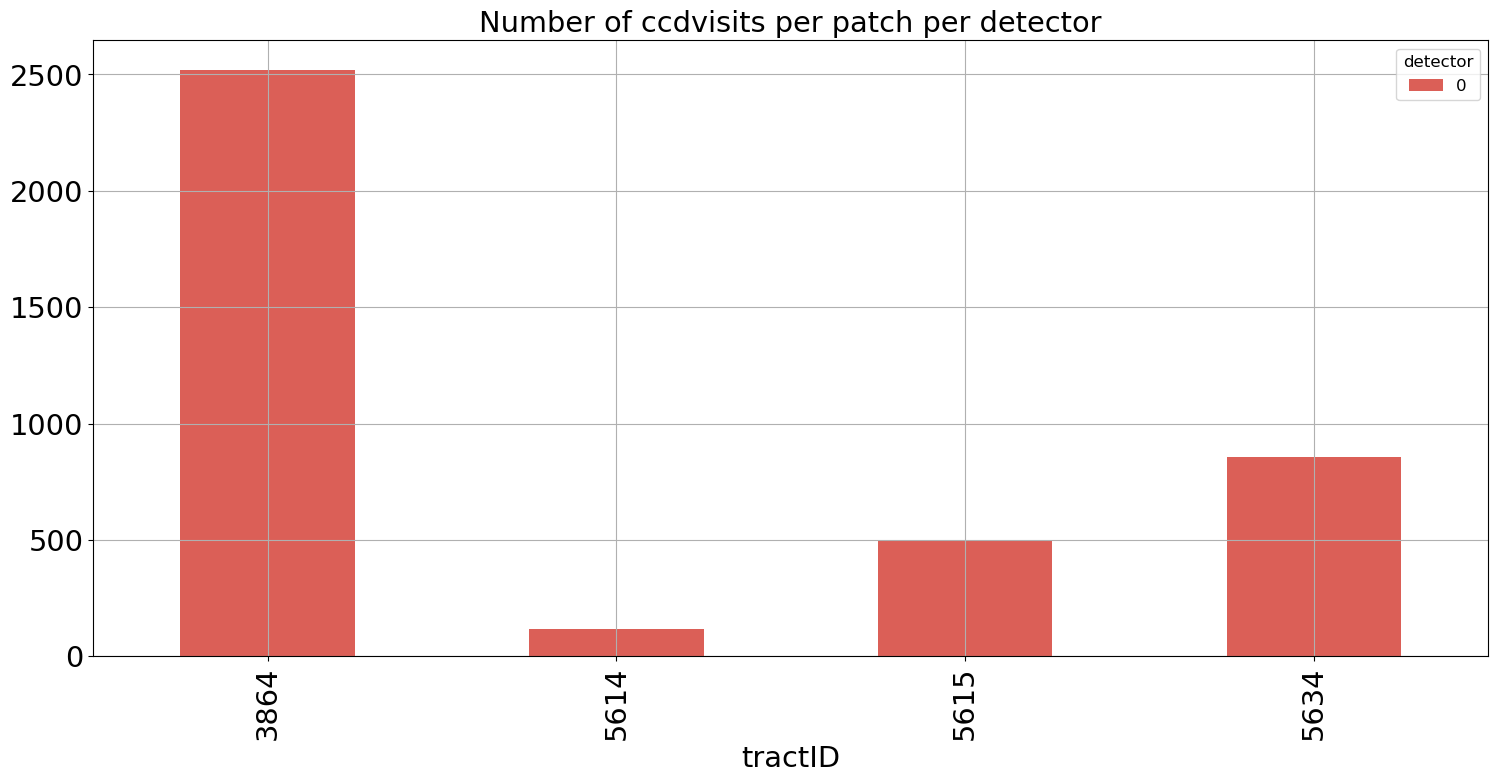

In [25]:
df_ccdvisit_pertractdet.plot.bar(color=all_det_colors,title="Number of ccdvisits per patch per detector",grid=True) 

In [26]:
ccd_visit_table_sel = ccd_visit_table[ccd_visit_table.tractID == tract_sel]

In [27]:
ccd_visit_table_sel

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,ccdVid,Vid,nightObs,tractID,patchID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
42496813824,2023111500491,SDSSg_65mm~empty,g,122.468450,-36.222238,24.011332,28.043152,6.788361,2.897027,7.524383,0.016227,0.010589,30,0.006487,-0.018941,0.010908,0.023753,-0.016147,0.045400,0.006656,0.216147,1667.859009,2.037226,0.021701,10.355442,0.302189,-36.222238,0,1.529980,359.999670,2023-11-16 07:21:40.837995,60264.306723,30.0,2023-11-16 07:21:25.837995,60264.306549,30.2359,4071,3999,122.402161,-36.276076,122.536428,-36.274708,122.534647,-36.168364,122.400562,-36.169731,1577116928,60400229,20231115,3864,237
42496814080,2023111500492,SDSSr_65mm~empty,r,122.468503,-36.222252,23.855350,27.821558,6.561609,4.592510,7.650120,0.014005,0.009276,44,0.002368,-0.003555,0.017276,0.010636,0.057125,0.071652,0.010740,0.383180,1670.125854,0.914483,0.023226,6.532375,0.200911,-36.222252,0,1.478751,359.999677,2023-11-16 07:22:27.471005,60264.307262,30.0,2023-11-16 07:22:12.471005,60264.307089,30.2362,4071,3999,122.402220,-36.276083,122.536482,-36.274715,122.534695,-36.168385,122.400615,-36.169751,1577117184,60400230,20231115,3864,237
42496814336,2023111500493,empty~SDSSi_65mm,i,122.468768,-36.222225,23.693943,27.912878,5.024981,11.789811,8.038830,0.007841,0.003959,92,-0.006165,-0.003918,0.020448,0.020010,0.032945,0.082392,0.016215,0.715460,1390.555298,0.718667,0.039603,2.544570,0.237717,-36.222225,0,1.132378,359.999732,2023-11-16 07:23:15.790002,60264.307822,30.0,2023-11-16 07:23:00.790002,60264.307648,30.2334,4071,3999,122.402483,-36.276053,122.536744,-36.274679,122.534961,-36.168362,122.400882,-36.169734,1577117440,60400231,20231115,3864,237
42496814592,2023111500494,SDSSg_65mm~empty,g,122.486654,-36.222253,23.419847,28.043514,5.318671,2.842179,7.491356,0.013368,0.006607,49,-0.001028,0.002589,0.009256,0.021044,0.016980,0.078685,0.014831,1.076333,2113.565674,3.384960,0.035350,10.555282,0.302391,-36.222253,0,1.198690,359.999718,2023-11-16 07:24:42.061498,60264.308820,30.0,2023-11-16 07:24:27.061498,60264.308647,30.2471,4071,3999,122.420370,-36.276090,122.554631,-36.274718,122.552846,-36.168378,122.418768,-36.169749,1577117696,60400232,20231115,3864,237
42496814848,2023111500495,SDSSr_65mm~empty,r,122.486693,-36.222281,23.264572,27.848112,4.842214,4.715397,7.623438,0.011540,0.006964,83,-0.000185,-0.008490,0.020011,0.019605,0.025840,0.075433,0.015477,0.728665,1195.650024,1.717450,0.042649,6.362137,0.210983,-36.222281,0,1.091243,359.999697,2023-11-16 07:25:28.539005,60264.309358,30.0,2023-11-16 07:25:13.539005,60264.309184,30.2276,4071,3999,122.420412,-36.276117,122.554667,-36.274740,122.552883,-36.168409,122.418810,-36.169783,1577117952,60400233,20231115,3864,237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43453134336,2024030800566,empty~SDSSy_65mm,y,122.493129,-36.203685,52.129131,26.166447,4.858362,13.559249,8.029708,0.016093,0.008375,56,0.003102,0.002562,0.026002,0.028631,0.004972,0.062312,0.012685,0.680248,1446.534058,0.026788,0.042366,2.212512,0.009526,-36.203685,0,1.094969,359.995886,2024-03-09 05:56:19.403505,60378.247447,30.0,2024-03-09 05:56:04.403505,60378.247273,30.2347,4071,3999,122.426835,-36.257489,122.561095,-36.256166,122.559331,-36.149845,122.425254,-36.151166,2533437440,979700304,20240308,3864,236
43453134592,20240308005

In [28]:
#llcra                                            279.122221
#llcdec                                           -48.010669
#ulcra                                            279.399948
#ulcdec                                           -47.881733
#urcra                                            279.589986
#urcdec                                           -48.064091
#lrcra                                            279.311725
#lrcdec                                           -48.193479

In [29]:
one_visit = ccd_visit_table_sel.iloc[0]

In [30]:
all_corners_ra = [one_visit["llcra"],
                  one_visit["ulcra"],
                  one_visit["urcra"],
                  one_visit["lrcra"],
                  one_visit["llcra"]]

In [31]:
all_corners_dec = [one_visit["llcdec"],
                  one_visit["ulcdec"],
                  one_visit["urcdec"],
                  one_visit["lrcdec"],
                  one_visit["llcdec"]]

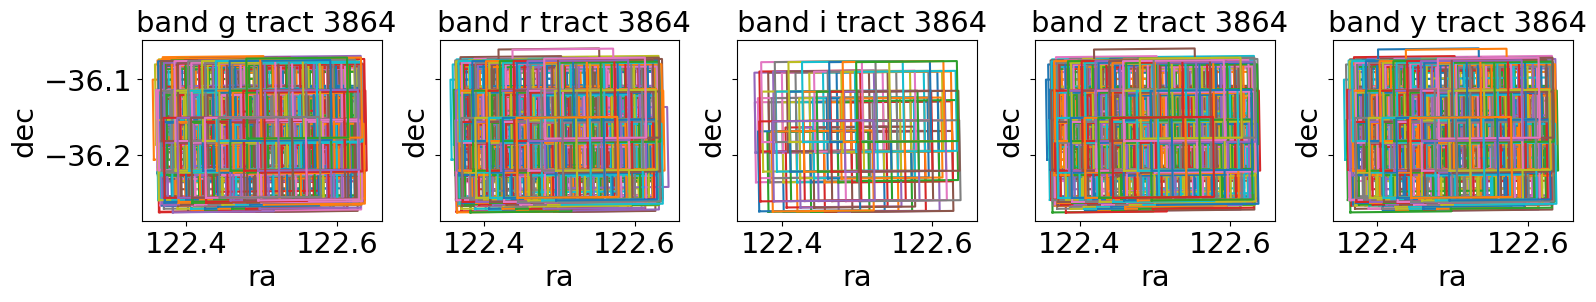

In [32]:
fig,axs = plt.subplots(1,5,figsize=(16,6),sharex=True,sharey=True)
                   
for index, one_visit in ccd_visit_table_sel.iterrows():
    band = one_visit["band"]
    if band == "g":
        ax = axs[0]
    elif band == "r":
        ax = axs[1]
    elif band == "i":
        ax = axs[2]
    elif band == "z":
        ax = axs[3]
    elif band == "y":
        ax = axs[4]
    else:
        pass
        
    ax.set_aspect('equal')
    
    all_corners_ra = [one_visit["llcra"],
                  one_visit["ulcra"],
                  one_visit["urcra"],
                  one_visit["lrcra"],
                  one_visit["llcra"]]
    all_corners_dec = [one_visit["llcdec"],
                  one_visit["ulcdec"],
                  one_visit["urcdec"],
                  one_visit["lrcdec"],
                  one_visit["llcdec"]]
    ax.set_title(f" band {band} tract {tract_sel}")
    ax.set_xlabel("ra")
    ax.set_ylabel("dec")
    ax.plot(all_corners_ra,all_corners_dec )

plt.tight_layout()